## 1. 데이터 구하기
#### 나스닥 차트 불러오기

In [1]:
import requests
import os

csv_file ='NQ=F.csv'

import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [2]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6171
삭제 후 데이터 길이(일자수): 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 2. 기본 통계분석으로 이상치 찾기
 - 데이터의 분포를 그려보기
 - z-test로 정규분포를 만족하는지 확인하기
 - (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기
#### 한 단계 더 나아가기
 - 왜 이상치로 분류됐는지 해석해보기
 - 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
 - 이상치들을 제거/교정해야할지 내버려둘지 고민하기

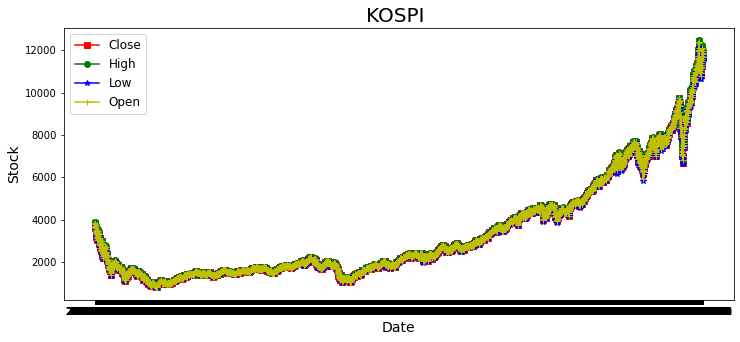

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [4]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


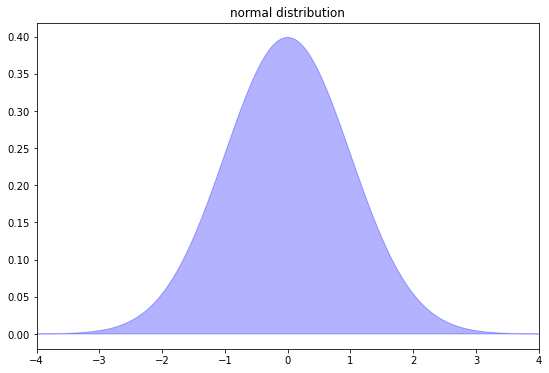

In [5]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

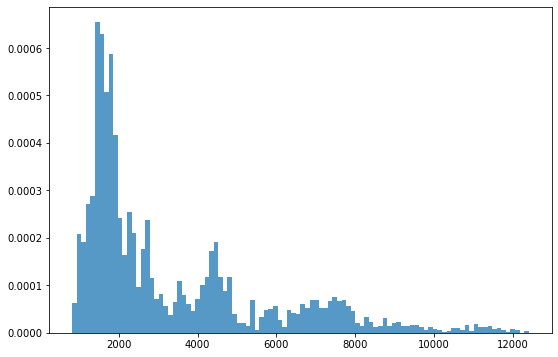

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [7]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


```
$ pip install statsmodels
```

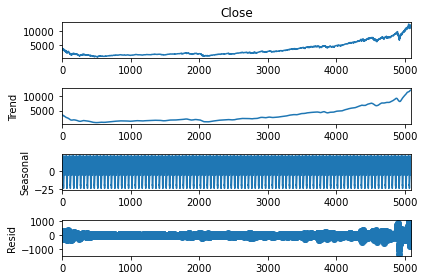

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

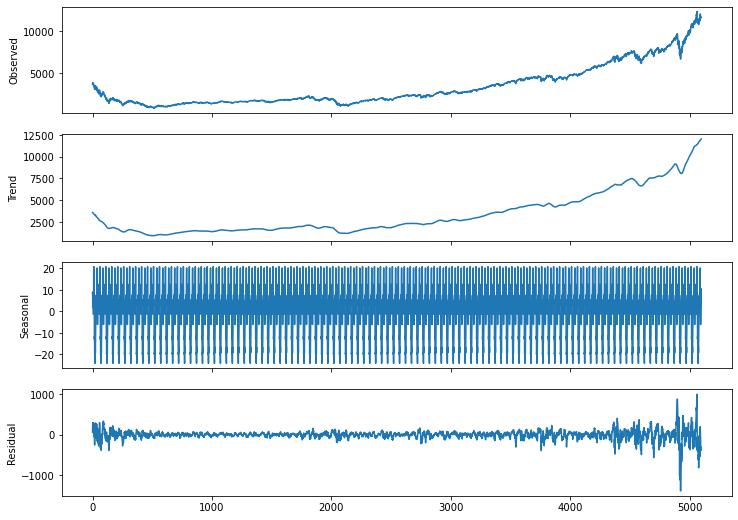

In [9]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

<AxesSubplot:>

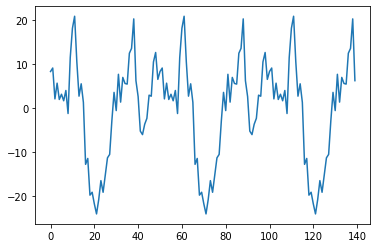

In [14]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:140].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

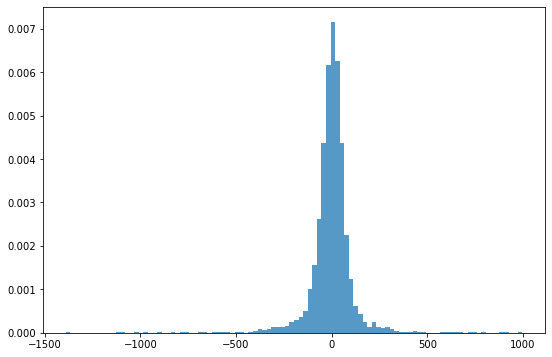

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [16]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8390076883668396 0.40146499522520807


### P-Valure = 0.4 로 아주 강함 = 정규분포로 가정하고 분석!

In [17]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2913972051412874 표준편차: 109.89901935436704
이상치 갯수: 92


In [18]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66      2000-12-20
73      2001-01-02
91      2001-01-29
92      2001-01-30
136     2001-04-03
           ...    
5083    2020-10-05
5084    2020-10-06
5085    2020-10-07
5096    2020-10-22
5097    2020-10-23
Name: Date, Length: 92, dtype: object

In [19]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [20]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


In [21]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

#### 통계적 방법과 Unsupervised Clustering 기법의 장점
적은 샘플 수로도 분석이 가능하다 (샘플 수가 50개 이상이면 적용 가능)
하드웨어 제약이 거의 없다
#### 통계적 방법과 Unsupervised Clustering 기법의 단점
Time series decomposition에 의존해야한다는 점
분석자의 주관이 필요하다는 단점이 있었습니다.
(통계기법:몇 배수의 표준편차?, k-means:몇개 그룹으로 클러스터링?, Time Series decompose: freq는 몇으로?)

## 3. Unsupervised Clustering 으로 이상치 찾기
 - k-means로 분석하기
 - DBSCAN으로 분석하기
 #### 한 단계 더 나아가기
 - 왜 이상치로 분류됐는지 해석해보기
 - 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
 - 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

### K-means로 이상치 탐색하기

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [23]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1099 3999]


In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:459',
 'group:1-count:352',
 'group:2-count:44',
 'group:3-count:239',
 'group:4-count:15',
 'group:5-count:19',
 'group:6-count:524',
 'group:7-count:45',
 'group:8-count:788',
 'group:9-count:181',
 'group:10-count:314',
 'group:11-count:47',
 'group:12-count:90',
 'group:13-count:115',
 'group:14-count:193',
 'group:15-count:7',
 'group:16-count:192',
 'group:17-count:746',
 'group:18-count:710',
 'group:19-count:18']

### 어떤날들이 분류된건지

In [25]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==2)|(kmeans.labels_==4)|(kmeans.labels_==5)|(kmeans.labels_==7)|(kmeans.labels_==15)|(kmeans.labels_==19)]

,Date,Open,High,Low,Close,Adj Close,Volume
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1757,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0
1863,2008-01-22,1851.500000,1858.250000,1744.500000,1801.000000,1801.000000,751476.0
1864,2008-01-23,1809.500000,1812.000000,1698.250000,1807.500000,1807.500000,888037.0
1983,2008-07-15,1802.750000,1833.500000,1765.250000,1799.000000,1799.000000,685484.0
...,...,...,...,...,...,...,...
5075,2020-09-23,11160.500000,11222.000000,10786.000000,10829.000000,10829.000000,656111.0
5076,2020-09-24,10803.500000,11011.799805,10660.200195,10891.799805,10891.799805,791934.0
5077,2020-09-25,10914.200195,11166.200195,10813.799805,11136.500000,11136.500000,600725.0
5082,2020-10-02,11566.799805,11604.799805,11204.500000,11233.200195,11233.200195,806629.0


In [26]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [37]:
# 2007-02-27 주변 정황
df.iloc[1639:1657]

,Date,Open,High,Low,Close,Adj Close,Volume
1639,2007-02-27,1837.50,1838.25,1744.25,1750.50000,1750.50000,774124.0
1640,2007-02-28,1750.25,1783.00,1743.25,1765.50000,1765.50000,521721.0
1641,2007-03-01,1764.50,1776.00,1720.00,1757.75000,1757.75000,662241.0
1642,2007-03-02,1757.25,1763.00,1724.25,1726.25000,1726.25000,463644.0
1643,2007-03-05,1726.00,1742.25,1704.75,1713.75000,1713.75000,572960.0
1644,2007-03-06,1714.75,1750.00,1711.00,1745.00000,1745.00000,422567.0
1645,2007-03-07,1744.75,1749.25,1735.50,1737.50000,1737.50000,339465.0
1646,2007-03-08,1737.75,1759.75,1733.25,1754.50000,1754.50000,208606.0
1647,2007-03-09,1754.25,1767.25,1735.25,1747.75000,1747.75000,108515.0
1648,2007-03-12,1749.00,1760.50,1739.50,1757.75000,1757.75000,84457.0


### 각 그룹의 특징

In [38]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.561742,-0.587771,-0.485877,-0.502296,-0.205888
1,0.716201,0.733180,0.647796,0.648150,0.351573
2,-0.459870,-0.730259,-1.380942,-1.507128,3.476067
3,0.101001,0.089810,-0.201208,-0.175296,1.720730
4,-6.025662,-5.785553,-5.911738,-5.407242,0.592845
5,6.092861,6.187818,6.208749,6.171515,-0.432828
6,0.472812,0.490853,0.558817,0.546282,-0.569675
7,-2.316989,-2.283548,-2.678565,-2.362616,2.439859
8,0.211506,0.239458,0.198241,0.205990,0.286078
9,1.126703,1.207496,1.260551,1.281581,-0.605462


- 4,15번 그룹이 전체적으로 다 작은 값을 가짐
- 5번 그룹은 유난히 큰 값을 가짐

#### 4번 그룹 

In [27]:
df[(kmeans.labels_==4)]

,Date,Open,High,Low,Close,Adj Close,Volume
4591,2018-12-26,5902.000000,6310.000000,5820.500000,6285.500000,6285.500000,642440.0
4699,2019-06-03,7110.000000,7132.500000,6941.250000,6993.750000,6993.750000,771723.0
4916,2020-03-12,7998.750000,8108.000000,7128.500000,7215.250000,7215.250000,876291.0
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0
4927,2020-03-25,7544.750000,7761.000000,7371.500000,7467.750000,7467.750000,656698.0
4930,2020-03-29,7395.750000,7507.250000,7367.250000,7489.250000,7489.250000,1256384.0
4934,2020-04-02,7473.500000,7656.250000,7376.000000,7627.250000,7627.250000,436829.0
4935,2020-04-03,7623.000000,7660.250000,7423.500000,7522.750000,7522.750000,351874.0


#### 2018-12-26 시초가가 유난히 낮은것을 볼 수 있는데, 전체적으로 미국 증시가 하락한 날이었음. 이유는 모르겠다..
#### 2019-06-03 트럼프가 멕시코 불법 이민자들에 대한 위협과 중국과의 무역갈등을 원인으로 급락함
#### 2020-3~4월은 코로나 때문에 주식이 폭락한 시기
#### 2020- 9월 에는 미국 국회의원들의 재정부양책에 뭐 영향인듯..

In [31]:
df.iloc[5065:5080]

,Date,Open,High,Low,Close,Adj Close,Volume
5065,2020-09-09,11006.000000,11478.799805,10935.200195,11392.799805,11392.799805,720954.0
5066,2020-09-10,11377.799805,11566.799805,11088.000000,11178.200195,11178.200195,885270.0
5067,2020-09-11,11187.000000,11356.200195,10937.500000,11061.500000,11061.500000,495802.0
5068,2020-09-14,11104.000000,11362.799805,11104.000000,11280.500000,11280.500000,322360.0
5069,2020-09-15,11278.500000,11495.500000,11247.799805,11464.200195,11464.200195,224404.0
5070,2020-09-16,11467.500000,11550.000000,11237.500000,11268.799805,11268.799805,167828.0
5071,2020-09-17,11269.500000,11302.500000,10918.799805,11090.000000,11090.000000,157390.0
5072,2020-09-18,11082.000000,11179.200195,11037.200195,11144.799805,11144.799805,800279.0
5073,2020-09-21,10920.000000,11009.799805,10656.500000,10989.000000,10989.000000,727984.0
5074,2020-09-22,10966.200195,11191.000000,10897.500000,11149.500000,11149.500000,573572.0


### 15번 그룹 

In [32]:
df[(kmeans.labels_==15)]

,Date,Open,High,Low,Close,Adj Close,Volume
4918,2020-03-15,7100.00,7978.00,6942.50,7215.25,7215.25,578813.0
4919,2020-03-16,7903.00,7905.25,6927.00,7057.50,7057.50,307368.0
4920,2020-03-17,7053.00,7552.25,6948.75,7405.25,7405.25,317501.0
4921,2020-03-18,7386.00,7392.25,6830.00,7225.25,7225.25,156283.0
4922,2020-03-19,7251.75,7521.50,6894.25,7293.50,7293.50,115519.0
4924,2020-03-22,6798.00,6798.00,6628.75,6688.75,6688.75,321230.0
4925,2020-03-23,6798.00,7316.25,6628.75,6984.50,6984.50,633237.0


### 15번 그룹 분석 결과 : 3월, 코로나로 인한 떡락

### 5 번 그룹

In [33]:
df[(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


### 코로나 직전 : 모르게씀..
### 코로나 직후 주식시장이 다시 활발해 지면서 지수 상승

### 특이치다. 특정한 원인에 의한 급락이기 때문에 제거 교정할 필요 없음.

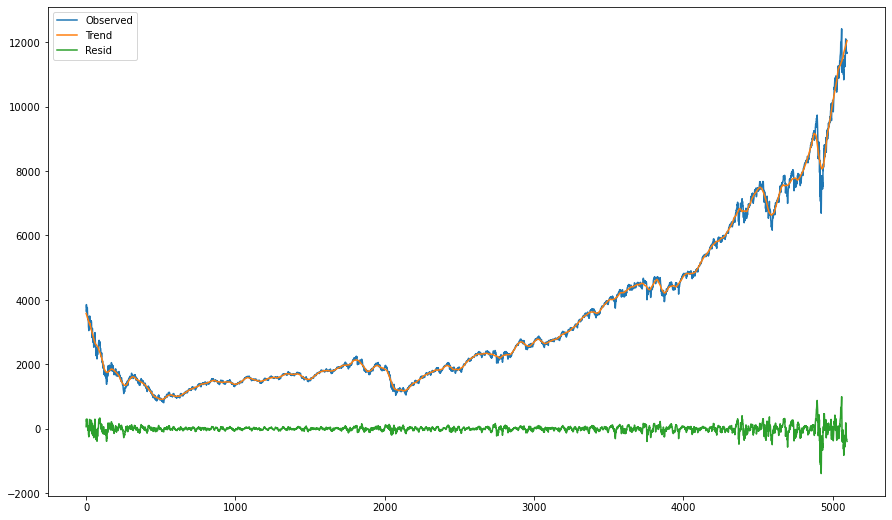

In [34]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

### DBSCAN 분석

In [35]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [36]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... 24 25 25]


In [37]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:197',
 'group:0-count:4839',
 'group:1-count:2',
 'group:2-count:2',
 'group:3-count:12',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:2',
 'group:8-count:3',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:3',
 'group:22-count:2',
 'group:23-count:2',
 'group:24-count:2',
 'group:25-count:2']

## Auto-Encoder를 이용한 이상치 탐색

#### 딥러닝 이상치 탐색의 장점
Time series decompostion 없이 분석 수행이 가능하다
Trend, Seasonal 데이터를 포함하고 있기 때문에 Trend, Seasonal의 변화도 이상치로써 탐색이 가능하다.
#### 딥러닝 이상치 탐색의 단점
분석자의 주관이 어느정도 필요하긴 하다 (Threshold, window)
학습에 활용할 만큼 충분한 데이터가 확보되어야한다.

## 4. LSTM 오토인코더로 이상치 찾기
- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기
#### 한 단계 더 나아가기
- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

In [38]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [39]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [40]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [41]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [42]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 32)            6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                2

In [43]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [44]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 3.0474 - mae: 3.0474
Epoch 00001: val_loss improved from inf to 3.14579, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 7s 42ms/step - loss: 3.0474 - mae: 3.0474 - val_loss: 3.1458 - val_mae: 3.1458
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 1.2791 - mae: 1.2791
Epoch 00002: val_loss improved from 3.14579 to 1.64848, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 6s 40ms/step - loss: 1.2791 - mae: 1.2791 - val_loss: 1.6485 - val_mae: 1.6485
Epoch 3/50
158/159 [============================>.] - ETA: 0s - loss: 0.7234 - mae: 0.7234
Epoch 00003: val_loss improved from 1.64848 to 1.11074, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 6s 40ms/step - loss: 0.7208 - mae: 0.7208 - val_loss: 1.1

In [45]:
model.load_weights(checkpoint_path)

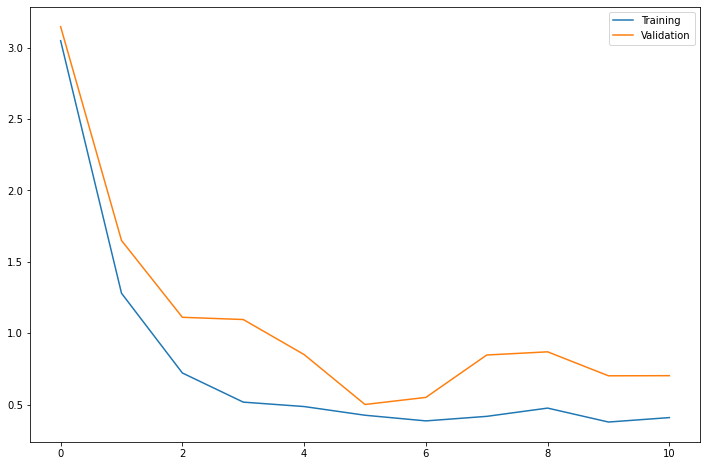

In [46]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

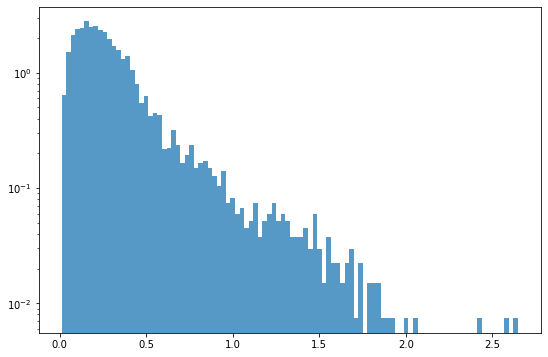

In [47]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [50]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.7
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.845995
4892,2020-02-25,9091.000000,9224.250000,8810.000000,8854.250000,8854.250000,1344897.0,1.887900
4893,2020-02-26,8868.250000,9037.500000,8709.500000,8850.250000,8850.250000,1251412.0,1.804225
4894,2020-02-27,8811.500000,8878.500000,8334.250000,8382.750000,8382.750000,1580041.0,2.593550
4895,2020-02-28,8347.000000,8574.750000,8126.250000,8454.000000,8454.000000,1527204.0,2.647670
4896,2020-03-01,8347.000000,8574.750000,8126.250000,8382.750000,8382.750000,1513887.0,2.432521
4897,2020-03-02,8349.250000,8883.250000,8224.250000,8791.250000,8791.250000,1373357.0,1.779889
5047,2020-08-28,11953.200195,12018.200195,11920.500000,11991.799805,11991.799805,489066.0,1.750140
5048,2020-08-30,12002.750000,12040.000000,11998.000000,12037.000000,12037.000000,354186.0,2.052910
5049,2020-08-31,12002.799805,12165.000000,11988.200195,12114.000000,12114.000000,480979.0,1.923240


In [51]:
threshold = 1.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4532,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.845995
4807,2019-11-10,8257.250000,8261.750000,8251.500000,8254.250000,8254.250000,60671.0,1.514196
4813,2019-11-17,8318.750000,8323.000000,8307.250000,8310.500000,8310.500000,145950.0,1.553780
4829,2019-12-08,8401.500000,8414.250000,8401.000000,8404.250000,8404.250000,96971.0,1.668138
4838,2019-12-18,8569.750000,8612.000000,8567.750000,8590.250000,8590.250000,98301.0,1.568087
4839,2019-12-19,8598.000000,8655.500000,8580.250000,8642.500000,8642.500000,65776.0,1.606403
4843,2019-12-26,8730.250000,8805.000000,8729.000000,8804.250000,8804.250000,170684.0,1.518950
4845,2019-12-29,8783.500000,8799.500000,8783.000000,8797.750000,8797.750000,164378.0,1.689417
4847,2019-12-31,8731.750000,8772.250000,8692.250000,8752.250000,8752.250000,284519.0,1.597201
4892,2020-02-25,9091.000000,9224.250000,8810.000000,8854.250000,8854.250000,1344897.0,1.887900


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


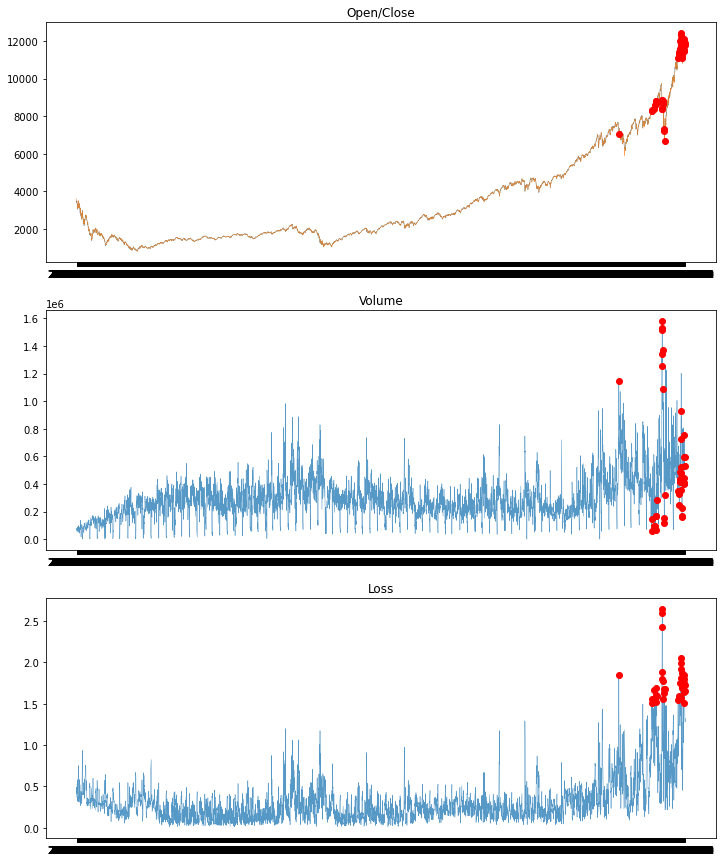

In [52]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

### 앞선 두가지 방법과 비교하기
 - 클러스터링은 조정해야 하는 값들(Cluster 군집 수, threshold 등)이 많았지만, 학습시킨 방법은 모델만 만들어 주면 쉽게 이상치를 찾아낼 수 있다.
### 다른 이유가 뭔지 확인해보기
 - 앞선 방법들과 비교했을때, 이상치를 찾아낸 결과는 비슷하다.
### 더 나은 형태의 오토인코더 모델을 만들어보기
 - LSTM에 layer 하나 추가함